# Solution to Barnstable and Long-Run Risk

## HBS Case

### *The Risk of Stocks in the Long-Run: The Barnstable College Endowment*

**Thanks to Tobias Rodriguez del Pozo (tobiasdelpozo@uchicago.edu)**

***

# 1. READING - Barnstable

### 1 Barnstable's Philosophy

* What has Barnstable's investment strategy been in the past?
* Explain the logic behind their view that stocks are safer in the long run.
* What assumptions underlie Barnstable's belief in the long-run safety of stocks?

<font color='red'>
1. Barnstable has mainly focused on US equities.
2. Their view is that over long periods of time, you achieve time diversification, eg. if your returns are i.i.d with some positive mean, then over a long period of time the average log returns will converge to the population mean. Therefore, assets with higher mean returns (stocks) become less risky over longer horizons.
3. Assuming uncorrelated returns (so i.i.d. long returns) across time.
</font>

### 2. Two proposals

Describe the two proposals Barnstable is considering for how to take advantage of their view regarding the long-run safety of stocks.

<font color='red'> 
1. Selling put options on the S&P 500 index. This provides additional cash flows in exchange for further downside risk. However, because of their belief in the long-run safety of stocks, they believe this risk is manageable.
2. Exposure to all the upside of the equity market, but is actually insuring against the downside risk as they simply return the asset if it underperforms the 6% strike growth rate.
<font>

### 3. The trust
How is the trust different from simply shorting the risk-free rate to take a levered position in stocks?

<font color='red'> 
Using a trust is functionally equivalent to borrowing at the risk free rate and leveraging into stocks. However, the trust has a 30-year commitment, meaning that their lenders cannot withdraw their money before maturity. This has the effect of allowing Barnstable to hold the investment for the long-run without liquidity risk.
</font>

### 4. Payoff differences

*You may not have had a course in options. It's okay if you are only vaguely familiar with the mechanics below and the option payoffs.*

Do these proposals take the same bet on long-run stock performance? In what outcomes will they have different returns?

The payoff at maturity of the common share is:

$$\Gamma_{30}^{\text{common}} = \max\left(\texttt{r}^m_{t,t+30} - \exp\left\{.06(30)\right\},~ 0\right)$$

The payoff at maturity of selling puts is:

$$\Gamma_{30}^{\text{selling puts}} = - \max\left(\exp\left\{.06(30)\right\} - \texttt{r}^m_{t,t+30}, 0\right)$$

<font color='red'>
The common shares are the same as buying call options on the stock with a growing strike price of 6% per year.

Preference shares have an exposure identical to being long the cumulative riskless rate of 6% and selling puts on the stock.

If we sum their payoffs we see that we end up at $r^m_{t,t+30}$, which is the payoff of a fully invested position in the stock.

</font>

### 5. Risk differences
Do the two proposals differ in their risk?

<font color='red'>
The risk profiles are enormously different. As described above, the put strategy means Barnstable has a huge liability with respect to stock under-performance. The trust strategy does not have any liability, as that is born by the preferred shareholders. There is a risk to long-run under-performance, and the trust neutralizes Barnstable from this risk while the put strategy loads into it.
</font>

### 6. Recommendation
Do you recommend a direct investment in the S&P, the trust or the puts?

<font color='red'>
The trust, it gets rid of Barnstable's liquidity risk when it comes to holding the position, and doesn't have the extreme tail risk that selling the puts does.
</font>

# 2. Estimating Underperformance

### Data

Use the returns on the S&P 500 ($r^m$) and 1-month T-bills, ($r^f$) provided in `barnstable_analysis_data.xlsx`.
* Data goes through `END_YR=2024`.

Barnstable's estimates of mean and volatility are based on the subsample of 1965 to 1999.
* We consider this subsample, as well as 2000-{END_YR}, as well as the full sample of 1926-{END_YR}.

### Notation

* $r$ = level return rates
* $R$ = cumulative return factor
* $\texttt{r}$ = log return rates

$$ R \equiv 1+r$$

$$ \texttt{r} \equiv \ln(1+r) = \ln(R)$$

### 1. Summary Statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("bmh")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]) : str(y[1])]
        res.append({"mean": sub.mean() * 12, "vol": sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index=[f"{i[0]} - {i[1]}" for i in agg_years]).stack()


df = pd.read_excel(
    "barnstable_analysis_data.xlsx", sheet_name="data", parse_dates=True, index_col=0
)
df["excess_returns"] = df["SPX"] - df["TB1M"]
df_subsample = df.loc["1965":"1999"]


agg_years = [(1965, 1999), (2000, 2024), (1926, 2024)]

sum_stats = df.apply(calc_analytics_by_year, agg_years=agg_years).T
log_sum_stats = np.log(1 + df).apply(calc_analytics_by_year, agg_years=agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product(
    [["levels", "logs"], sum_stats.index.to_list()]
)
res_stats.style.format("{:,.2%}")

- Comment on how the full-sample return stats compare to the sub-sample stats.
- Comment on how the level stats compare to the log stats.

<font color='red'>
There is a noticeable difference between the sub-sample periods and full-sample. Specifically, from 1965-1999, SPX averaged 13% annualized returns compared to 8.75% from 2000-2024. Additionally, the risk-free rate was much lower in the later period compared to the earlier one. 

Note that the excess returns are not actually higher in the period in the later period, as the risk-free rate was much lower. The log returns show lower mean returns as expected.
</font>

### 2. Probability of Underperformance

Recall the following:
- If $x\sim\mathcal{N}\left(\mu_x,\sigma_x^2\right)$, then

  $$\Pr\left[x<\ell\right] = \Phi_\mathcal{N}\left(L\right)$$

  where $L = \frac{\ell-\mu_x}{\sigma_x}$ and $\Phi_\mathcal{N}$ denotes the standard normal cdf.

- Remember that cumulative log returns are simply the sum of the single-period log returns:
  
  $$\texttt{r}^m_{t,t+h} \equiv \sum_{i=1}^h \texttt{r}^m_{t+i}$$

- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$:
  
  $$\bar{\texttt{r}}^m_{t,t+h} = \frac{1}{h}\sum_{i=1}^h \texttt{r}^m_{t+i}$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return:

$$\Pr\left[R^m_{t,t+h} < R^f_{t,t+h}\right]$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

#### 2.1 - 2.3
2.1. Calculate the probability using the subsample 1965-1999.

2.2. Report the precise probability for $h=15$ and $h=30$ years.

2.3. Plot the probability as a function of the investment horizon, $h$, for $0<h\le 30$ years.

**Hint**: The probability can be expressed as:

$$p(h) = \Phi_{\mathcal{N}}\left(-\sqrt{h}\;\text{SR}\right)$$

where $\text{SR}$ denotes the sample Sharpe ratio of **log** market returns.

SPX underperforming risk-free rate in the 15 years after 1999: 7.16%
SPX underperforming risk-free rate in the 30 years after 1999: 1.92%


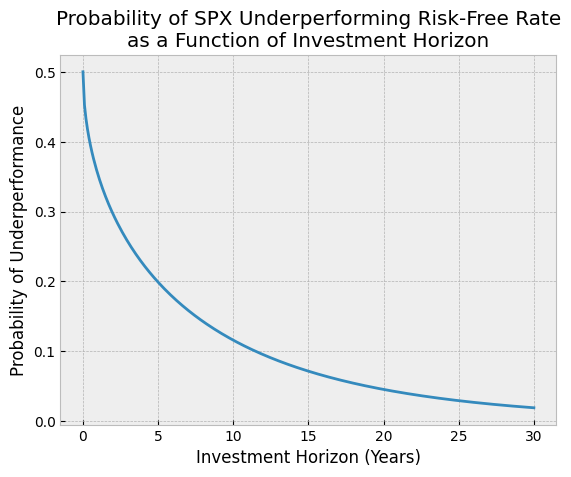

In [2]:
def prob_underperformance(mu, sigma, h):
    return norm.cdf(np.sqrt(h) * (-mu / sigma))


mu, sigma = res_stats["1965 - 1999"].loc[("logs", "excess_returns")]

print(
    f"SPX underperforming risk-free rate in the 15 years after 1999: {prob_underperformance(mu=mu, sigma=sigma, h=15):,.2%}"
)
print(
    f"SPX underperforming risk-free rate in the 30 years after 1999: {prob_underperformance(mu=mu, sigma=sigma, h=30):,.2%}"
)

h = np.linspace(0, 30, 300)

probabilities = prob_underperformance(mu=mu, sigma=sigma, h=h)


plt.plot(h, probabilities)
plt.title(
    "Probability of SPX Underperforming Risk-Free Rate\nas a Function of Investment Horizon"
)
plt.xlabel("Investment Horizon (Years)")
plt.ylabel("Probability of Underperformance")
plt.show()

### 3. Full Sample Analysis

Use the sample 1965-{END_YR} to reconsider the 30-year probability. As of the end of {END_YR}, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R^m_{t,t+h}$ underperforming $R^f_{t,t+h}$ for $0<h\le 30$.

<font color='red'>
Note that this is the same as checking whether or not the expected excess return is negative over the next 30 years.
</font>

In [3]:
# 1965-2024 period
mu = np.log(1 + df.loc["1965":"2023"]).mean() * 12
sigma = np.log(1 + df.loc["1965":"2023"]).std() * np.sqrt(12)
h = np.arange(30) + 1

mu_excess = mu["excess_returns"]
sigma_excess = sigma["excess_returns"]

probabilities_full_sample = prob_underperformance(mu=mu_excess, sigma=sigma_excess, h=h)
print(
    f"SPX underperforming risk-free rate in the 30 years after 2024: {prob_underperformance(mu=mu_excess, sigma=sigma_excess, h=30):,.2%}"
)

SPX underperforming risk-free rate in the 30 years after 2024: 2.35%


### 4. In-Sample Estimate of Out-of-Sample Likelihood

Let's consider how things turned out relative to Barnstable's 1999 expectations.

What was the probability (based on the 1999 estimate of $\mu$) that the `h`-year market return, $R^m_{t,t+h}$, would be smaller than that realized in `2000-{END_YR}`? 

**Hint**: You can calculate this as:

$$p = \Phi_{\mathcal{N}}\left(\sqrt{h}\; \frac{\bar{\texttt{r}}_{out-of-sample} - \bar{\texttt{r}}_{\text{in-sample}}}{\sigma_{\text{in-sample}}}\right)$$

where "in-sample" denotes 1965-1999 and "out-of-sample" denotes 2000-{END_YR}.

In [4]:
mu = (
    res_stats[("1965 - 1999", "mean")].loc[("logs", "SPX")]
    - res_stats[("2000 - 2024", "mean")].loc[("logs", "SPX")]
)
sigma = res_stats[("1965 - 1999", "vol")].loc[("logs", "SPX")]

print(
    f"Probability of underperformance in 2000-2024: {prob_underperformance(mu, sigma, 24):,.2%}"
)

Probability of underperformance in 2000-2024: 8.42%


***

# Further Reading

## Zvi Bodie's Paper

Highly recommend reading **"On the Risk of Stocks in the Long Run" by Zvi Bodie**.

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5771

### Are stocks less risky in the long run?

*The basis for the proposition that stocks are less risky in the long run appears to be
the observation that the longer the time horizon, the smaller the probability of a shortfall.
If the ex ante mean rate of return on stocks exceeds the risk-free rate of interest, it is
indeed true that the probability of a shortfall declines with the length of the investment
time horizon. For example, suppose the rate of return on stocks is lognormally distributed
with a risk premium of 8% per year and an annualized standard deviation of 20%. With a
time horizon of only 1 year, the probability of a shortfall is 34%, whereas at 20 years that
probability is only 4%.
But as has been shown in the literature, the probability of a shortfall is a flawed
measure of risk because it completely ignores how large the potential shortfall might be.*

### Stocks are not a long-run hedge to rates

*Stocks are not a hedge against fixed-income liabilities even in the long run. Exactly the opposite is the case: When a pension plan sponsor invests the pension assets in stocks, the actuarial present value cost to the PBGC of providing a guarantee against a shortfall increases rather than decreases with the length
of the time horizon, even for plans that might start out fully funded.*

### Are Stocks a Long-run Inflation Hedge

*With stocks there is no certainty of value — real or nominal — at any date in the
future.*